## 281 Computational - HW2
### Facundo Pernigotti

## Problem 1: Policy Function Iteration and Value Function Iteration


Using the problem from class, we compare the speed and accuarcy of:

1. Standard value function iteration
2. Value function iteration with policy iteration improvement step.
3. Policy function iteration.


In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar, bisect
import matplotlib.pyplot as plt
import time


In [2]:
# same setup as before
# max_iter = 2000
# max_iter_policy = 1000
#tolerance = 1e-7

# fix parameters beta, r, and y
beta = 0.99
r = (1/beta) - 1
y = 1
amin = -1
amax = 1
grid_size = 500

# define asset grid
a = np.linspace(amin, amax, grid_size)

# define utility function --- makes it easy to change later
def utility(c):
    return np.log(c)

def margutility(c):
    return 1 / c 

def invmargutility(u):
    return 1 / u 



In [3]:
def iterate(type, max_iter, tolerance, max_iter_policy=None,):
    start_time = time.time()
    if type == "VFI":
        iteration = 0
        iteration_policy=0 
        v0 = np.linspace(1, 10, grid_size)
        v_new = v0

        # Howard iteration in value function consumption problem
        while iteration < max_iter:
            v_old = v_new
            c_candidates = y + np.linspace(-0.5, 0.5, 500)
            a_prime_candidates = (1+r)*a[np.newaxis, :] + y - c_candidates[:, np.newaxis]
            f_interp = interp1d(a, v_old, kind='linear', bounds_error=False, fill_value=(-10000, 0))
            v_prime_candidates = f_interp(a_prime_candidates)
            utility_values = utility(c_candidates[:, np.newaxis]) + beta * v_prime_candidates
            c_index = np.argmax(utility_values, axis=0)
            c = c_candidates[c_index]
            v_new = np.max(utility_values, axis=0)

            c_policy = c
            u_policy=utility(c_policy)
            a_prime_policy= (1+r)*a + y - c_policy
            while iteration_policy < max_iter_policy:
                f_interp = interp1d(a, v_new, kind='linear', bounds_error=False, fill_value=(-10000,0))
                v_prime = f_interp(a_prime_policy)
                v_new = u_policy+ beta * v_prime
                iteration_policy += 1

            if np.max(np.abs(v_new - v_old)) < tolerance:
                end_time = time.time()  # Record the end time
                execution_time = round(end_time - start_time,4)
                print(f'VFI with {max_iter_policy} policy iterations: Converged after {iteration} iterations and {execution_time} seconds')
                break
            iteration += 1

        return c, execution_time
    
    elif type == "PFI" :
        c_0 = y + np.zeros(a.shape)

        # the implied next period assets are
        aprime = (1 + r) * a + y - c_0

        iteration =0 
        c_new=c_0
        c_old=c_0
        update= 0.95
        
        while iteration < max_iter:
            c_old=c_new * update + c_old* (1-update)
            a_prime= (1+r) * a + y - c_old


            #interpolate c_o
            f_interp= interp1d (a, c_old,  kind='linear', bounds_error=False, fill_value=(0.0001,(1 + r) * amax + y))
            cprime=f_interp(a_prime)

            c_new=invmargutility(beta * (1+r) * margutility(cprime))                    

            if np.max(np.abs(c_new-c_old)) < tolerance: 
                end_time = time.time()  # Record the end time
                execution_time = round(end_time - start_time,4)
                print(f'Policy Function Iteration: Converged after {iteration} iterations and {execution_time} seconds')
                break
            iteration +=1
        
        return c_new, execution_time

In [4]:
c_1, t1 =iterate(type="VFI", max_iter=2000, max_iter_policy=0, tolerance = 1e-7)
c_2, t2 =iterate(type="VFI", max_iter=2000, max_iter_policy=2000, tolerance = 1e-7)
c_3, t3 =iterate(type="PFI", max_iter=2000, tolerance = 1e-7)


VFI with 0 policy iterations: Converged after 1365 iterations and 4.8345 seconds
VFI with 2000 policy iterations: Converged after 759 iterations and 3.3465 seconds
Policy Function Iteration: Converged after 705 iterations and 0.0587 seconds


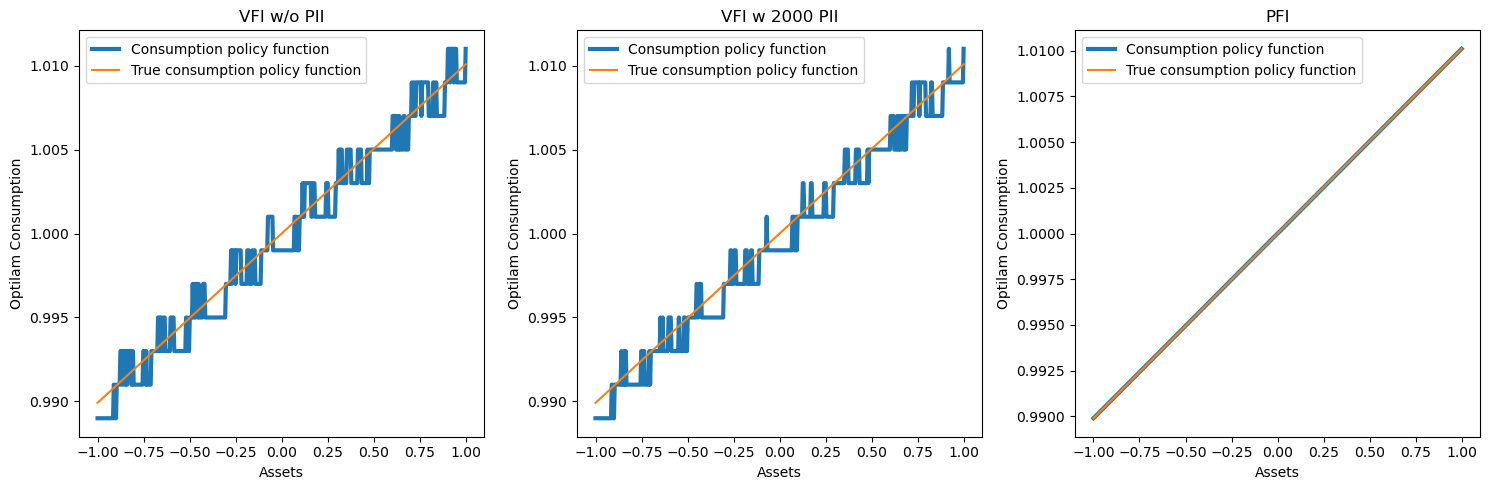

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(a, c_1, linewidth=3, label='Consumption policy function')
axs[0].plot(a, y + r * a, label='True consumption policy function')
axs[0].set_xlabel('Assets')  
axs[0].set_ylabel('Optilam Consumption')  
axs[0].set_title('VFI w/o PII')  
axs[0].legend() 

axs[1].plot(a, c_2, linewidth=3, label='Consumption policy function')
axs[1].plot(a, y + r * a, label='True consumption policy function')
axs[1].set_xlabel('Assets')  
axs[1].set_ylabel('Optilam Consumption')  
axs[1].set_title('VFI w 2000 PII')  
axs[1].legend() 

axs[2].plot(a, c_3, linewidth=3, label='Consumption policy function')
axs[2].plot(a, y + r * a, label='True consumption policy function')
axs[2].set_xlabel('Assets')  
axs[2].set_ylabel('Optilam Consumption')  
axs[2].set_title('PFI')  
axs[2].legend() 

plt.tight_layout()
plt.show()

We can see that Policy Function iteration is significantly faster than value function iteration with or without policy function improvement ( 0.05 seconds compared to 4 and 7) and also is more accuarate at computing the policy function. This last feature could be explained by the fact that we chose to minimize the error in policy function instead of the difference between value functions. 

Minor comment about jupyter: I defined the times as t1, t2 and t3 so I could call them directly in the previous code but it did not let me use {{ t1 }} as it is supposed to. I couldn't figure out why.

## Problem 2: Newton-Raphson method


First we define a function for the Newton Raphson method:

In [6]:
def newton_raphson(func, a, b, x0, tol=1e-6, max_iter=100000):
    """
    Find a root of a function using Newton-Raphson method.

    Parameters:
        func : callable
            The function whose root is to be found.
        x0 : float
            Initial guess for the root.
        tol : float, optional
            Tolerance level for convergence. Default is 1e-6.
        max_iter : int, optional
            Maximum number of iterations. Default is 100.

    Returns:
        root : float
            Approximated root of the function.
    """
    a = a
    b = b
    x = x0
    iter_count = 0
    
    while True:
        iter_count += 1
        if iter_count > max_iter:
            raise ValueError("Maximum number of iterations reached.")
        
        f_val = func(x)
        if abs(f_val) < tol:
            return x
        
        # Compute the derivative of the function at x
        f_prime = (func(x + tol) - func(x - tol)) / ( tol)
        
        # Update x using Newton-Raphson formula
        if x - f_val / f_prime < a:
            x=a
        elif x - f_val / f_prime > b: 
            x=b
        else :
            x -= f_val / f_prime

Now we set up the market clearing problem as in class.

Converged after 3344 iterations.


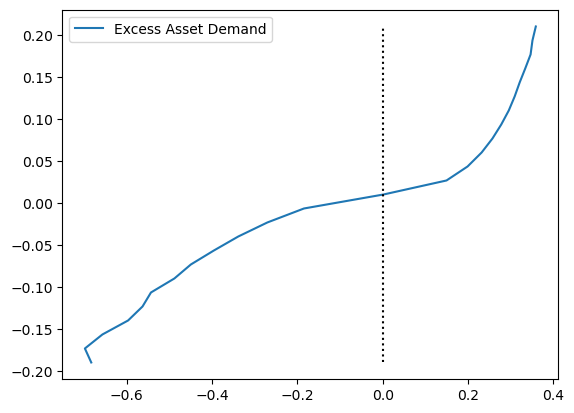

In [7]:
a = np.linspace(amin, amax, grid_size)
asupply=0

index = np.argmin(np.abs(a-asupply))

def excess_demand(r):
    iteration =0 
    max_iter=5000
    tolerance = 1e-7
    c_new= y + np.zeros(a.shape)
    c_old=c_new
    
    update= 0.2
    
    while iteration < max_iter:
        c_old= c_new * update + c_old* (1-update)
        a_prime= (1+r) * a + y - c_old


        #interpolate c_o
        f_interp= interp1d (a, c_old,  kind='linear', bounds_error=False, fill_value=(0.0001,(1 + r) * amax + y))
        cprime=f_interp(a_prime)

        c_new=invmargutility(beta * (1+r) * margutility(cprime))                    

        if np.max(np.abs(c_new-c_old)) < tolerance: 
            print(f'Converged after {iteration} iterations.')
            break
            
        iteration +=1
        
    excess_demand = a_prime[index] -asupply
    return excess_demand
    
            
# plot consumption against true consumption function
A = 0.5
r_candidates =  (1/beta) - 1 + np.linspace(-0.2, 0.2, 25)
excess_demand_values = np.zeros(25)
for i, r in enumerate(r_candidates):
    excess_demand_values[i] = excess_demand(r)

plt.plot(excess_demand_values, r_candidates, label=f'Excess Asset Demand')
plt.plot(np.zeros_like(r_candidates), r_candidates, 'k:')
plt.legend()
plt.show()

And finally we find the equilibrium interest rate with both methods. 

In [8]:
def excess_demand_function(x):
    # Assuming excess_demand_values is an array or a function that takes a single argument x
    # You should replace this with the appropriate way to evaluate your excess_demand_values
    excess_demand_values_interp=interp1d( r_candidates , excess_demand_values)
    return excess_demand_values_interp(x)

start_time1 = time.time()
rstar1=bisect(excess_demand_function,-0.075, 0.075)
end_time1 = time.time()  # Record the end time
execution_time1 = round(end_time1 - start_time1,4)
print(rstar1)
print(f'Bisection: Converged after {execution_time1} seconds')

start_time2 = time.time()
rstar2=newton_raphson(excess_demand_function,-0.075, 0.075, -0.075)
end_time2 = time.time()  # Record the end time
execution_time2 = round(end_time2 - start_time2,4)
print(rstar2)
print(f'Newton Raphson: Converged after {execution_time2} seconds')

start_time3 = time.time()
rstar3=newton_raphson(excess_demand_function,-0.075, 0.075, -0.18)
end_time3 = time.time()  # Record the end time
execution_time3 = round(end_time3 - start_time3,4)
print(rstar3)
print(f'Newton Raphson: Converged after {execution_time3} seconds')


0.00992168441334798
Bisection: Converged after 0.0031 seconds
0.009921760230719986
Newton Raphson: Converged after 0.0023 seconds
0.009921760230719986
Newton Raphson: Converged after 0.002 seconds


In this case they both reach the same number in about the same time, although the bisect method seems to work just a little faster. This likely depends on the shape of the function and how large the boundaries are.

## Problem 3:  FOC from Value Function


From an initial guess $V'_0(a)$, we can derive $c(a)=u'^{-1}(V'_0(a))$  which give us $a'(a)$. 

Then, we can update our value function as $V'_1(a)= \beta (1+r) V'_0(a')$


<!-- $V'_0(a'(a))=\dfrac{V'_0(a)}{\beta (1+r)}$. Then, we will construct $V'_1(a)=V'_0(a')$ and iterate until these two are equal -->


In [9]:
def iterate(max_iter, tolerance, verbose=True, print_skip=25):
        start_time = time.time()
        iteration = 0
        iteration_policy=0 
        vprime0 = np.linspace(0.9,1.1 , grid_size)
        vprime_new = vprime0
        vprime_old = vprime0
        
        update = 0.6
        while iteration < max_iter:
            vprime_old = vprime_new * update + vprime_old * (1-update)
            
            c_pf = 1 / vprime_old
            a_prime = ( 1 + r ) * a + y - c_pf
            
            #interpolate v'_0
            f_interp= interp1d (a, vprime_old,  kind='linear', bounds_error=False, fill_value=(-100,100))
            vprime_old_aprime=f_interp(a_prime)
            
            vprime_new=beta * (1+r) * vprime_old_aprime
            
            if verbose and i % print_skip == 0:
                error=np.max(np.abs(vprime_new-vprime_old))
                print(f"Error at iteration {i} is {error}.")

            if np.max(np.abs(vprime_new-vprime_old)) < tolerance: 
                end_time = time.time()  # Record the end time
                execution_time = round(end_time - start_time,4)
                print(f'FOC VF iteration: Converged after {iteration} iterations and {execution_time} seconds')
                break
        
            iteration +=1
        
        return c_pf, vprime_new

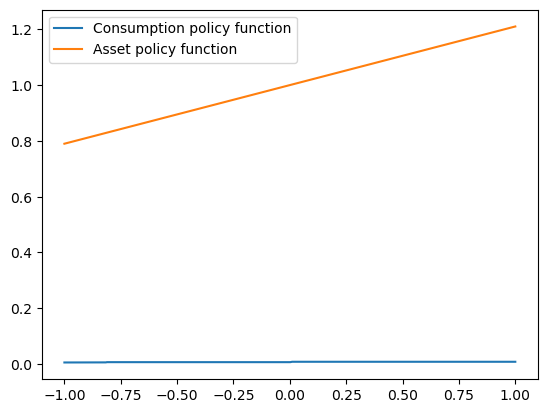

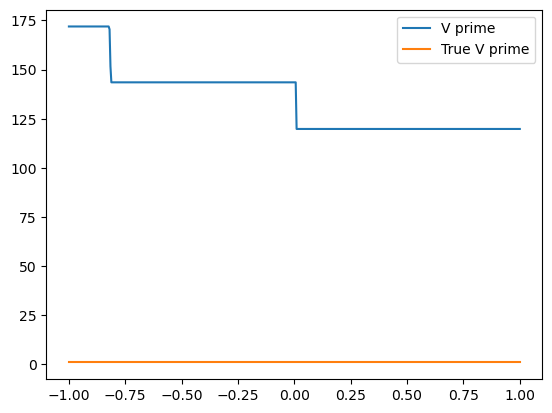

In [10]:
c4, v1 =iterate(max_iter=10000, tolerance = 1e-7)

# plot consumption against true consumption function
plt.plot(a, c4, label='Consumption policy function')
plt.plot(a, y + r * a, label='Asset policy function')
plt.legend()
plt.show()

# plot against true value function
plt.plot(a, v1, label='V prime')
plt.plot(a, np.ones(grid_size), label='True V prime')
plt.legend()
plt.show()

I can't get it to converge.